In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

import keras_tuner as kt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers
from matplotlib import pyplot as plt
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tqdm.auto import tqdm
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

sys.path += ['..']
from readers.base import NeuralynxReader, OpenEphysReader, buffer

2022-04-08 14:39:42.517497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 14:39:42.517528: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tf.config.list_physical_devices('GPU')

2022-04-08 13:42:18.533959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[]

2022-04-08 13:42:18.534221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-08 13:42:18.534354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-08 13:42:18.766528: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-04-08 13:42:18.766779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2022-04-08 13:42:18.767014: W tensorflow/stream_executor/platform/default/dso_loader

## Stellagama

CPU times: user 1.11 s, sys: 2.78 s, total: 3.9 s
Wall time: 3.92 s


666.6666666666666

42242970

ShW: 1.3-3.5sec (2.4sec)
ShW_broken: 1.8-4.2sec (3.0sec)
spindles: 0.4-26.9sec (4.2sec)
saw: 1.3-41.5sec (9.3sec)
small_ShW: 0.6-2.1sec (1.1sec)


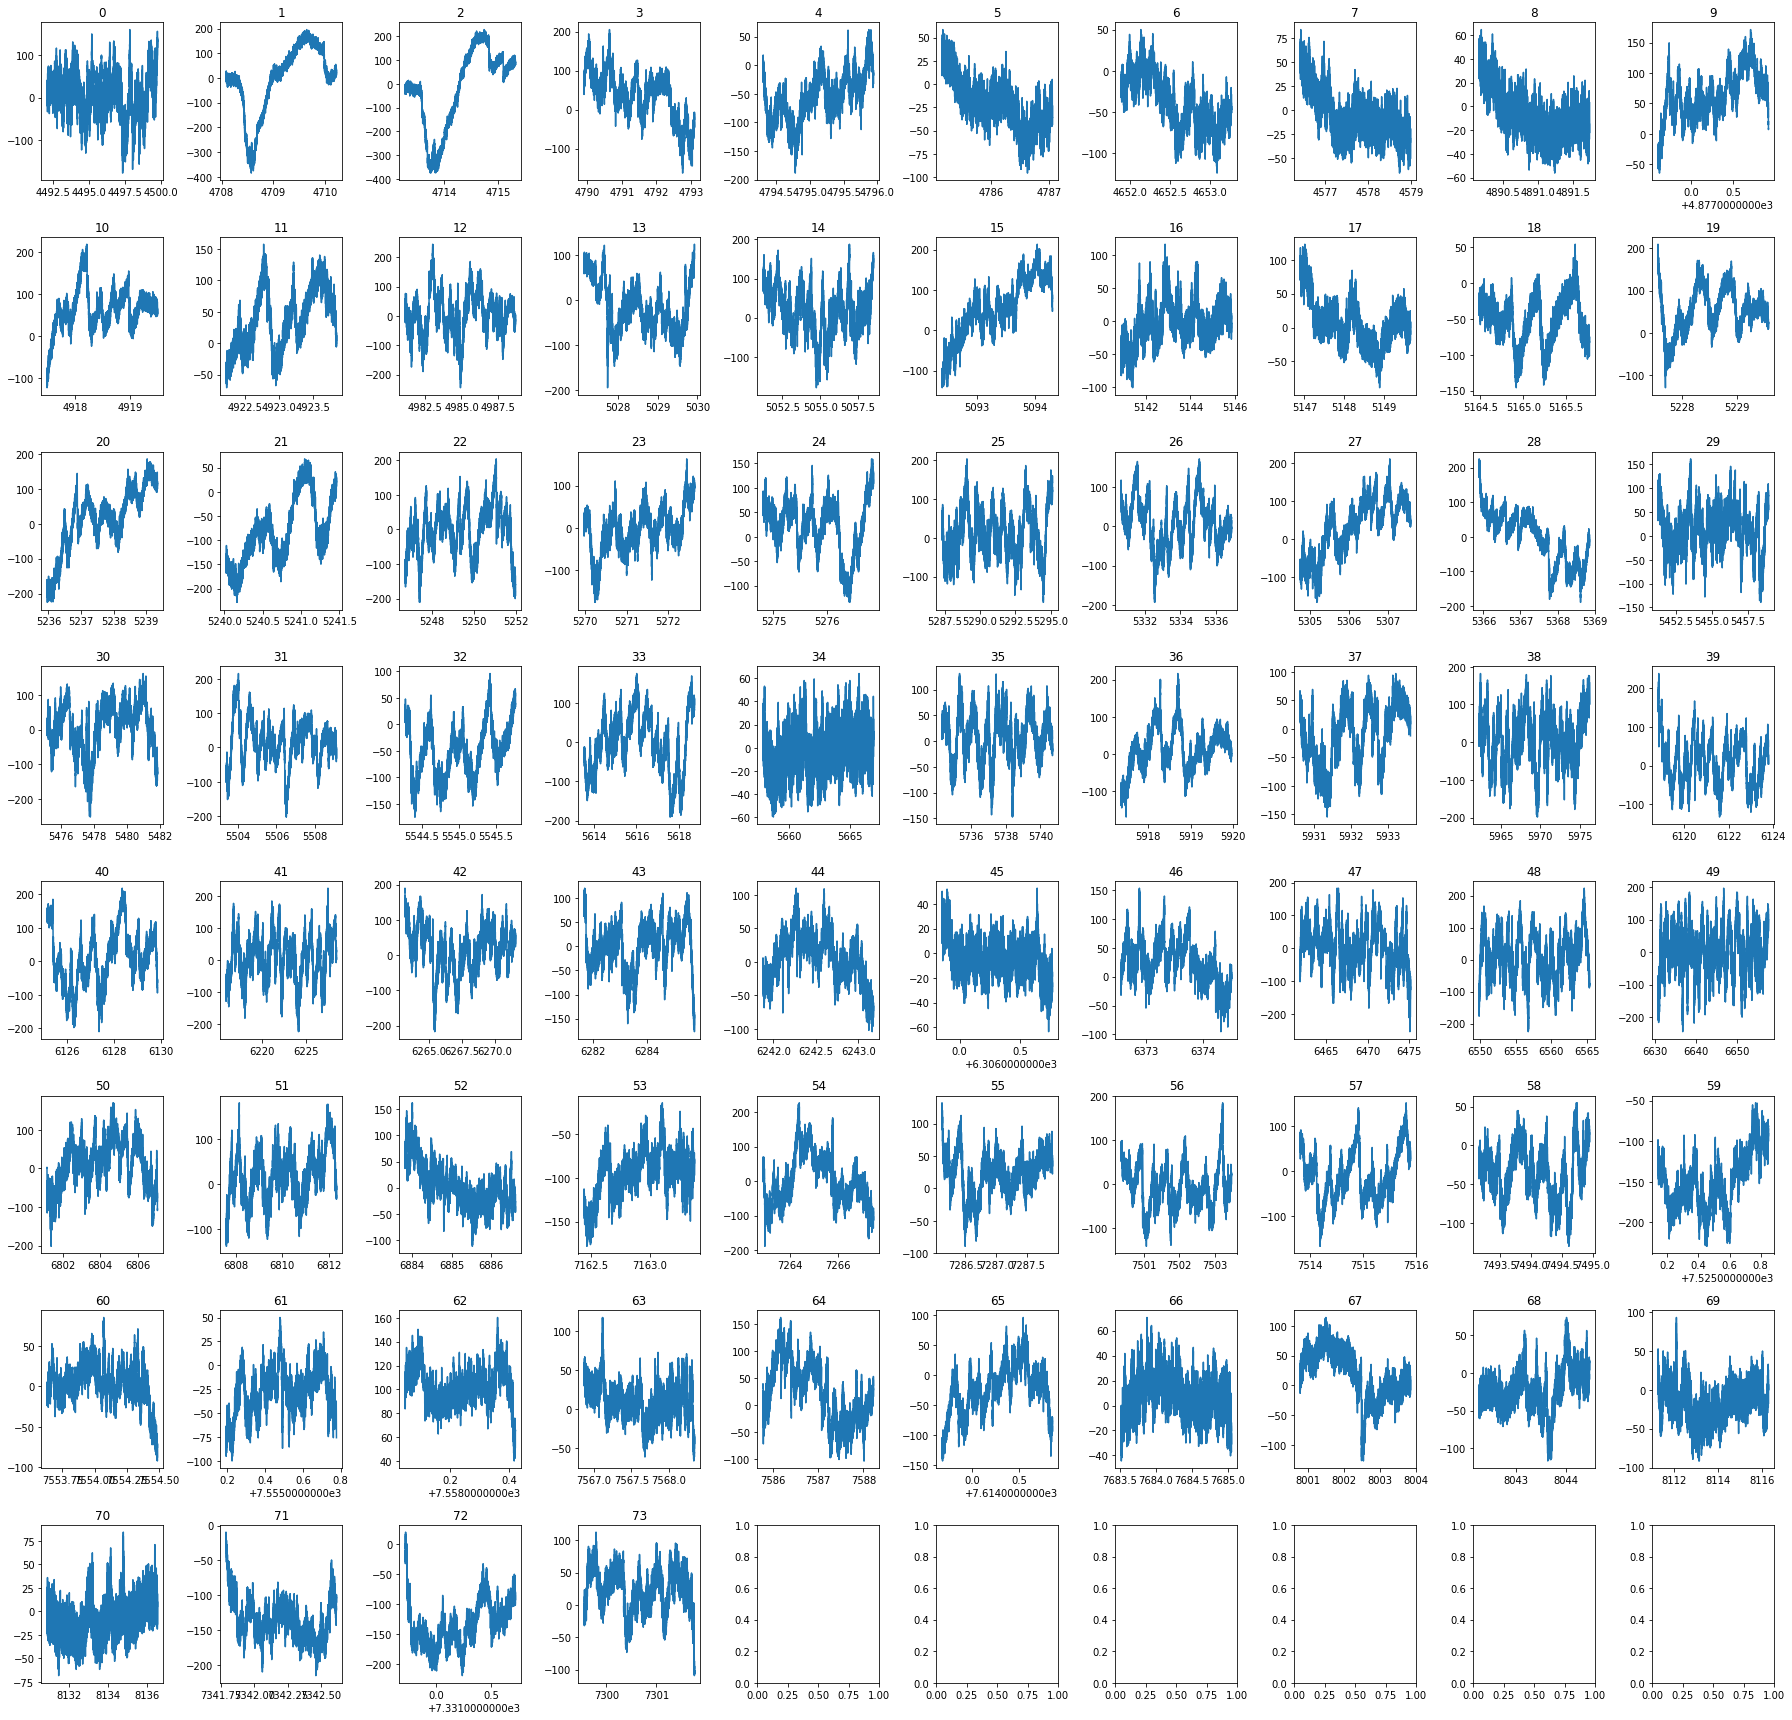

In [11]:
plot_annotations('spindles')

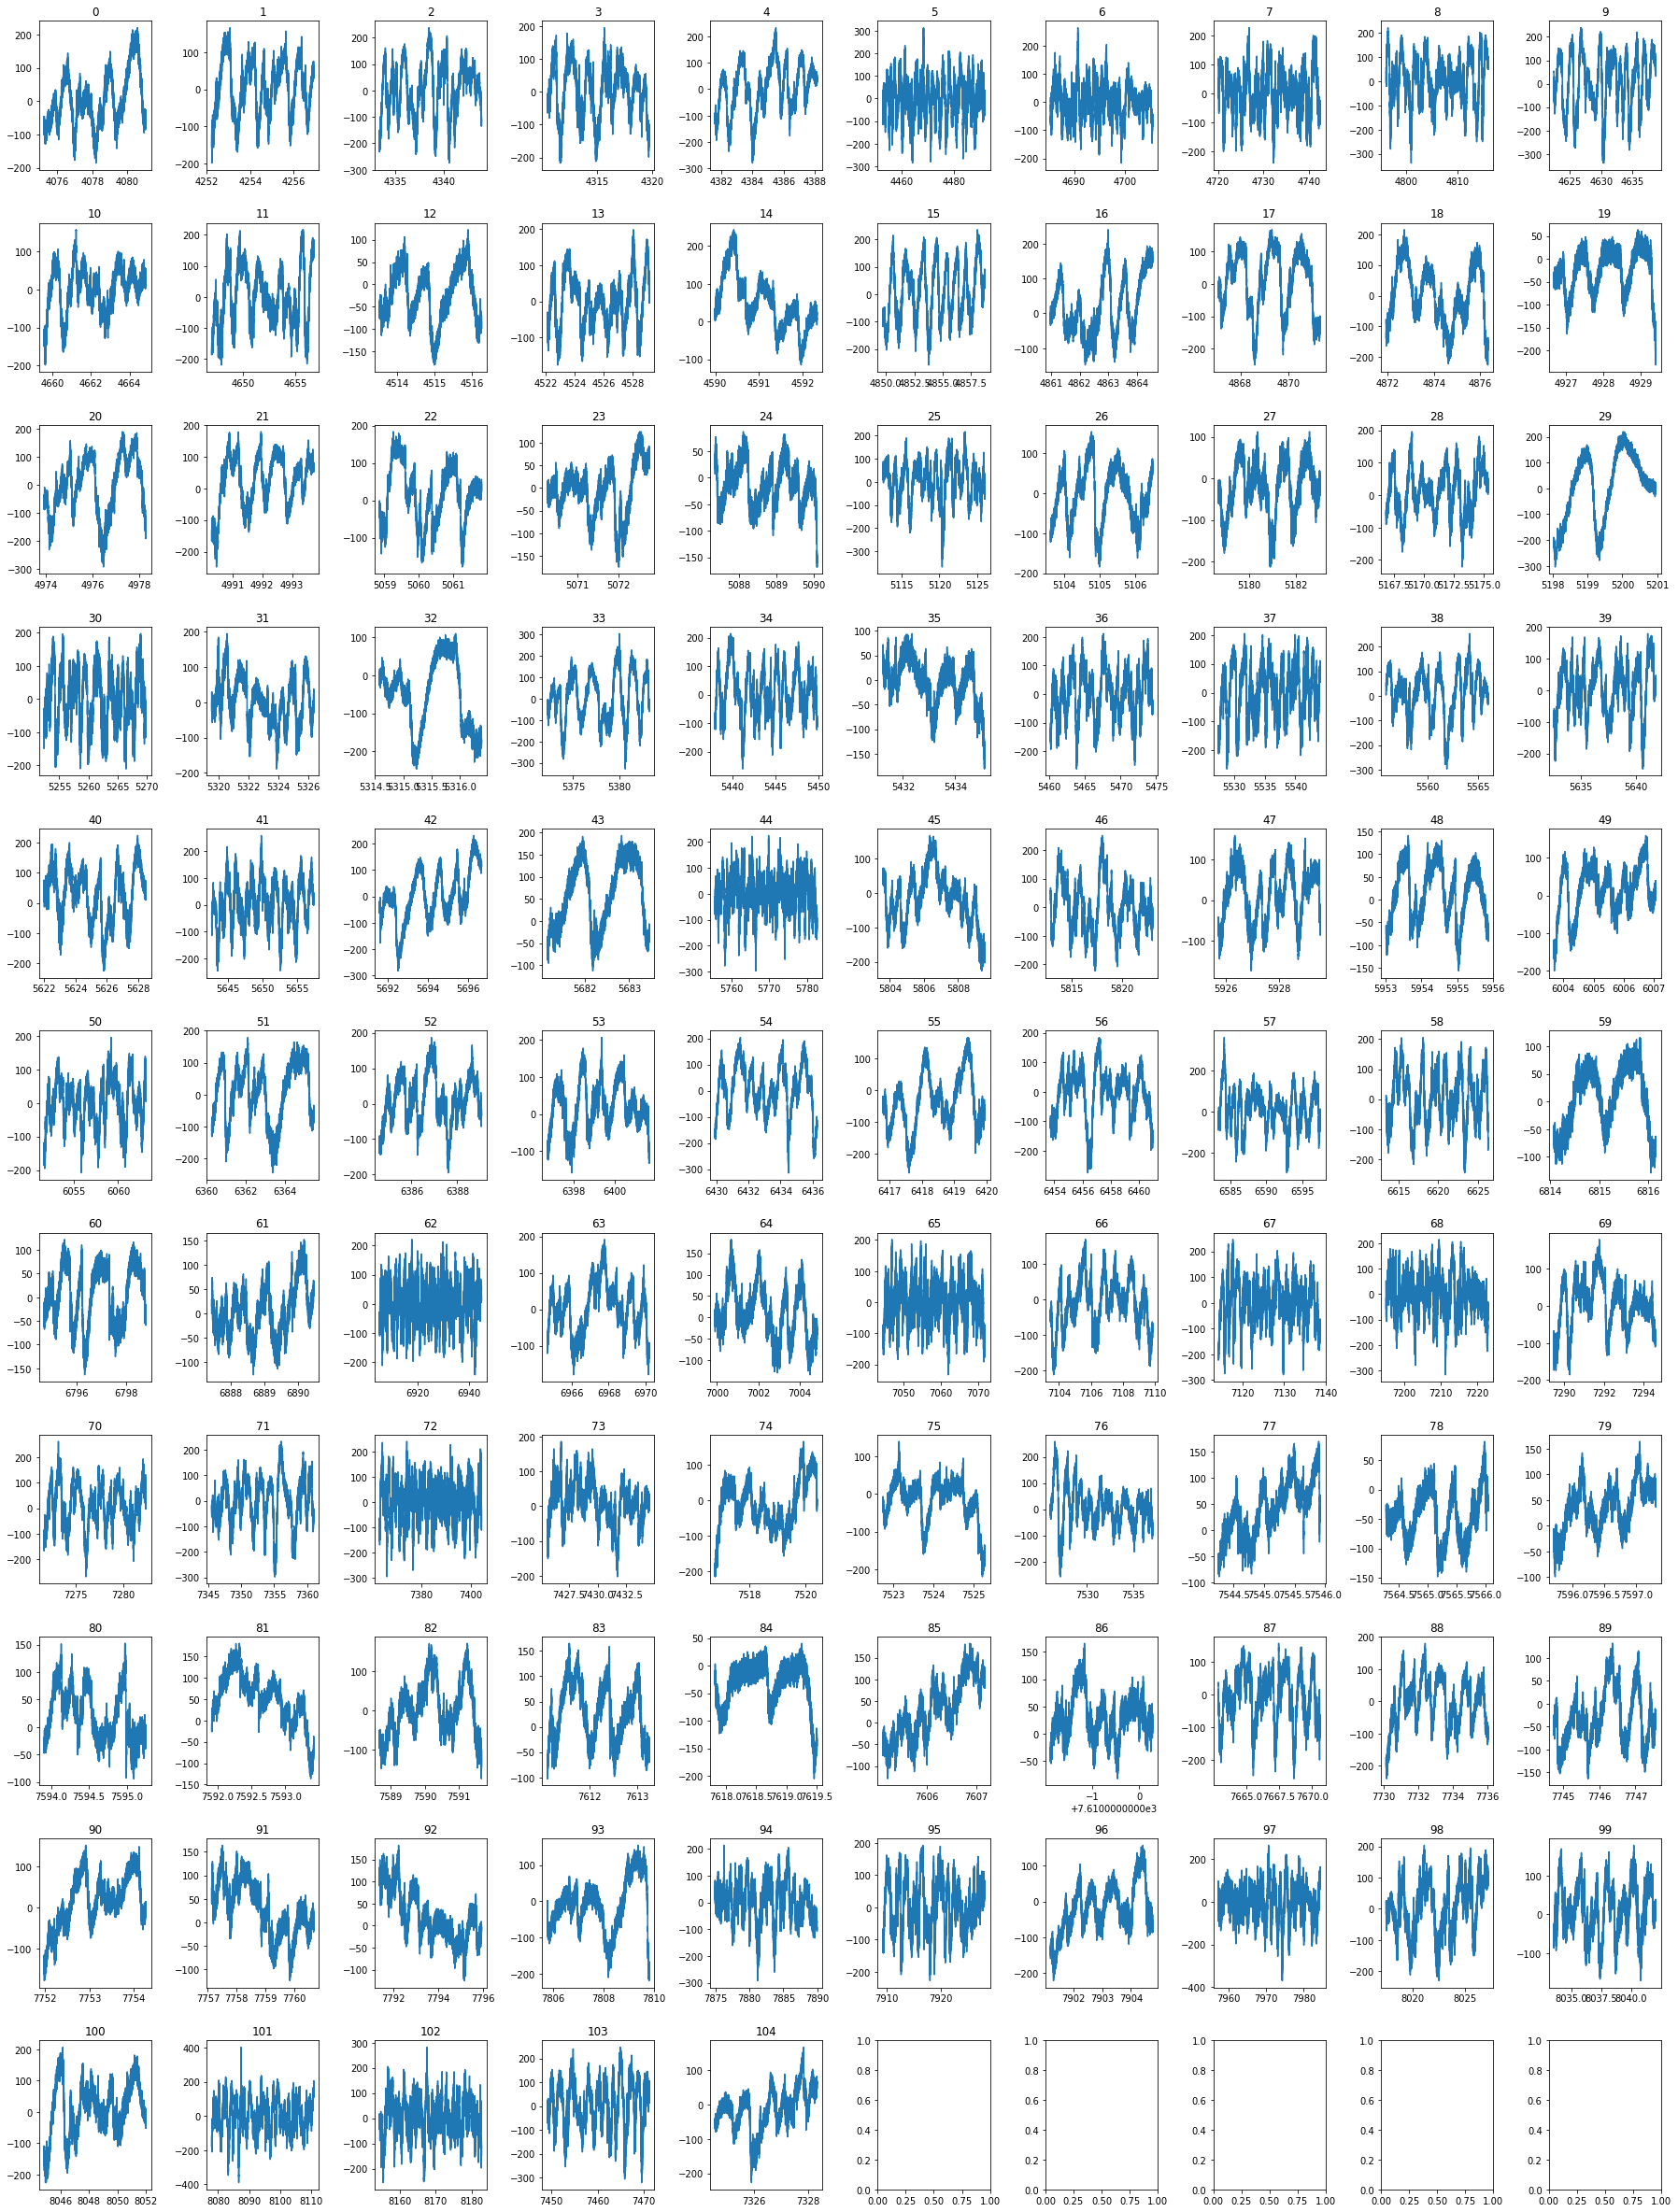

In [12]:
plot_annotations('saw')

## Pogona

In [2]:
%%time
rd = NeuralynxReader('/media/sil2/Lizard/lorenz_data/2019-11-17_17-43-33', channel=32, lowpass=150, decimate_q=20, wavelet=None, window=1.5, overlap=0.5,
                     use_multiprocessing=False, use_slow_cycles=False, is_flat_cwt=False)
x_train, _, _ = rd.read_segmented(i_start=int(2*3600*rd.fs), i_stop=int(4*3600*rd.fs))
x_train.shape

Buffered Matrix size: (9598, 2400)
Number of segments after buffering: 9598
start creation of sig_df...


  0%|          | 0/9598 [00:00<?, ?it/s]

CPU times: user 16.4 s, sys: 3.75 s, total: 20.1 s
Wall time: 34.3 s


(9598, 2400)

In [ ]:
rd = NeuralynxReader('/media/sil2/Lizard/lorenz_data/2019-11-17_17-43-33', channel=32, lowpass=100, decimate_q=20, wavelet=None, window=1.5, overlap=0.5,
                     use_multiprocessing=False, use_slow_cycles=False, is_flat_cwt=False)
v, t = rd.read(i_start=int(2*3600*rd.fs), i_stop=int(2.5*3600*rd.fs))

## Train

In [7]:
# savemat('../output/annotation_set.mat', {'x_train': x_train, 'labels': labels})
m = loadmat('../output/annotation_set.mat')
x_train, labels = m['x_train'], m['labels']

In [12]:
x_train, labels = build_annotation_set()
x_train.shape

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
if len(x_train.shape) == 2:
    x_train = x_train.reshape((*x_train.shape, 1))
scaler = TimeSeriesScalerMeanVariance()
x_train = scaler.fit_transform(x_train)
x_train, x_test = train_test_split(x_train, test_size=0.1)
print(f'Train set shape: {x_train.shape}')
print(f'Test set shape: {x_test.shape}')

Train set shape: (1031, 1332, 1)
Test set shape: (115, 1332, 1)


In [11]:
savemat('/media/sil2/Data/regev/stellagama/annotation_set.mat', {'x_train': x_train, 'x_test': x_test, 'labels': labels})

In [9]:
def build_model(hp):
    kernel_size = hp.Int("kernel_size", min_value=7, max_value=57, step=5)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.8, step=0.1)
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(rate=dropout_rate),
            layers.Conv1D(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Flatten(),
            layers.Conv1DTranspose(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(rate=dropout_rate),
            layers.Conv1DTranspose(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    print(model.summary())
    return model

def conv_ae(kernel_size, dropout_rate, latent_dim):
    encoder = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Conv1D(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(latent_dim, name='latent_layer'),
        ]
    )
    volume_size = K.int_shape(encoder.layers[-3].output)
    decoder = keras.Sequential(
        [
            layers.Input(shape=(latent_dim,)),
            layers.Dense(np.prod(volume_size[1:])),
            layers.Reshape((volume_size[1], volume_size[2])),
            layers.Conv1DTranspose(filters=16, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=32, kernel_size=kernel_size, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=dropout_rate),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, padding="same")
        ]
    )
    inputs = encoder.inputs
    autoencoder = keras.Model(inputs, decoder(encoder(inputs)), name="autoencoder")
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    print(autoencoder.summary())
    return autoencoder, encoder, decoder

def tune_conv_ae(hp):
    kernel_size = hp.Int("kernel_size", min_value=7, max_value=57, step=5)
    dropout_rate = hp.Float("dropout_rate", min_value=0.05, max_value=0.8, step=0.05)
    latent_dim = hp.Int("latent_dim", min_value=2, max_value=30, step=1)
    autoencoder, _, _ = conv_ae(kernel_size, dropout_rate, latent_dim)
    return autoencoder

In [10]:
tuner = kt.RandomSearch(
    hypermodel=tune_conv_ae,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="ae",
    project_name="lfp-ae-latent",
)
tuner.search(x_train, x_train,
             epochs=30,
             validation_data=(x_test, x_test),
             callbacks=[
                 keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
             ])
tuner.results_summary()

2022-04-08 14:42:25.261642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 14:42:25.261808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-08 14:42:25.261921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-08 14:42:25.267914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-04-08 14:42:25.268056: W tensorflow/stream_executor/platform/default/dso_loader

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1332, 1)]         0         
                                                                 
 sequential (Sequential)     (None, 2)                 14706     
                                                                 
 sequential_1 (Sequential)   (None, 1332, 1)           21825     
                                                                 
Total params: 36,531
Trainable params: 36,339
Non-trainable params: 192
_________________________________________________________________
None

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
47                |?                 |kernel_size
0.2               |?                 |dropout_rate
14                |?                 |latent_dim

Model: "autoencoder"
________________________________________________________

KeyboardInterrupt: 

In [69]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2400, 1)]         0         
                                                                 
 sequential (Sequential)     (None, 21)                221989    
                                                                 
 sequential_1 (Sequential)   (None, 2400, 1)           241041    
                                                                 
Total params: 463,030
Trainable params: 462,838
Non-trainable params: 192
_________________________________________________________________
None


In [ ]:
best_model.get

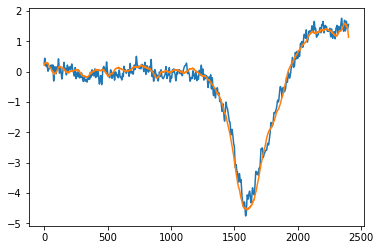

In [64]:
i = 8
x = x_test[i:i+1,:,:]
pred = best_model.predict(x)
plt.plot(x.flatten())
plt.plot(pred.flatten())

In [66]:
vars(best_model)

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_input_spec': None,
 '_build_input_shape': TensorShape([None, 2400, 1]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 2400, 1), dtype=tf.float32, name='input_1'),
 '_saved_model_arg_spec': ([TensorSpec(shape=(None, 2400, 1), dtype=tf.float32, name='input_1')],
  {}),
 '_supports_masking': True,
 '_name': 'autoencoder',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7efafc95da90>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f354e5b4240>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_self_tracked_trackables': [<kera

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2400, 1)]         0         
                                                                 
 sequential_4 (Sequential)   (None, 21)                221989    
                                                                 
 sequential_5 (Sequential)   (None, 2400, 1)           241041    
                                                                 
Total params: 463,030
Trainable params: 462,838
Non-trainable params: 192
_________________________________________________________________
None


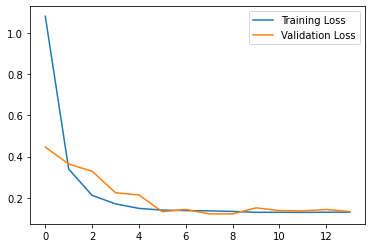

In [93]:
ae, encoder, _ = conv_ae(kernel_size=37, dropout_rate=0.5, latent_dim=21)
history = ae.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

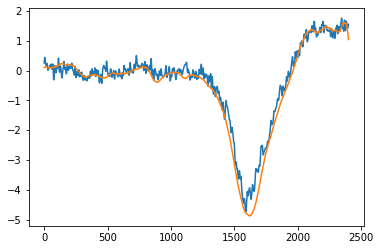

In [94]:
i = 8
x = x_test[i:i+1,:,:]
pred = ae.predict(x)
plt.plot(x.flatten())
plt.plot(pred.flatten())

In [95]:
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
encoded = np.vstack([encoded_train, encoded_test])
encoded.shape

(9598, 21)

In [81]:
enc_scaler = StandardScaler()
encoded = enc_scaler.fit_transform(encoded)

In [91]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1, min_samples=20).fit(encoded)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 7436


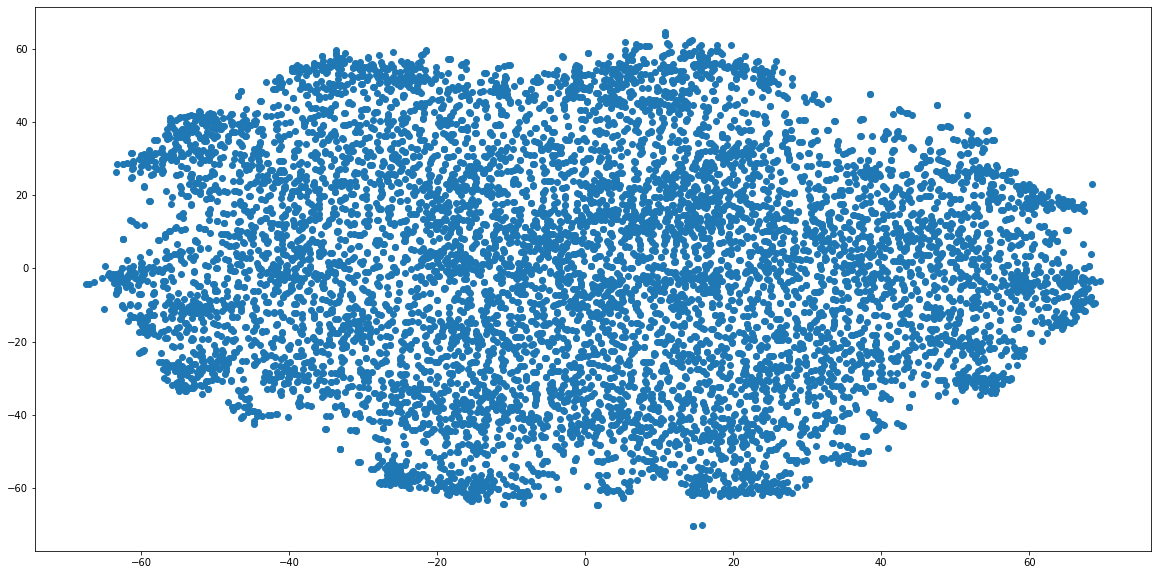

In [97]:


# enc_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(encoded)
plt.figure(figsize=(20, 10))
plt.scatter(enc_embedded[:,0], enc_embedded[:,1])